In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_probability as tfp
import gensim
import random
import matplotlib.pyplot as plt
from bvae import *
from text_data_utils import *

TensorFlow 2.x selected.


In [2]:
language_wv = gensim.models.KeyedVectors.load_word2vec_format("w2v_format_summaries_vectors.txt")
code_wv = gensim.models.KeyedVectors.load_word2vec_format("w2v_format_codes_vectors.txt")
assert language_wv.vector_size == code_wv.vector_size
wv_size = language_wv.vector_size

max_len = 200
train_summaries, train_codes = load_iyer_file("train.txt", max_len=max_len)
val_summaries, val_codes = load_iyer_file("valid.txt", max_len=max_len)
test_summaries, test_codes = load_iyer_file("test.txt", max_len=max_len)

train_summaries = tokenized_texts_to_tensor(train_summaries, language_wv, max_len)
val_summaries = tokenized_texts_to_tensor(val_summaries, language_wv, max_len)
test_summaries = tokenized_texts_to_tensor(test_summaries, language_wv, max_len)

train_codes = tokenized_texts_to_tensor(train_codes, code_wv, max_len)
val_codes = tokenized_texts_to_tensor(val_codes, code_wv, max_len)
test_codes = tokenized_texts_to_tensor(test_codes, code_wv, max_len)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [4]:
latent_dim = 256
model = BimodalVariationalAutoEncoder(train_summaries.shape[1], train_codes.shape[1], latent_dim, wv_size)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002))

history = model.fit((train_summaries, train_codes), None, batch_size=128, epochs=65,
                    validation_data=((val_summaries, val_codes), None))

Train on 51750 samples, validate on 6475 samples
Epoch 1/65
51750/51750 [==============================] - 23s 446us/sample - loss: 1.3339 - val_loss: 1.0223
Epoch 2/65
51750/51750 [==============================] - 22s 419us/sample - loss: 1.0005 - val_loss: 0.9477
Epoch 3/65
51750/51750 [==============================] - 22s 419us/sample - loss: 0.9466 - val_loss: 0.9113
Epoch 4/65
51750/51750 [==============================] - 22s 418us/sample - loss: 0.9146 - val_loss: 0.8834
Epoch 5/65
51750/51750 [==============================] - 22s 418us/sample - loss: 0.8860 - val_loss: 0.8584
Epoch 6/65
51750/51750 [==============================] - 22s 419us/sample - loss: 0.8616 - val_loss: 0.8348
Epoch 7/65
51750/51750 [==============================] - 22s 419us/sample - loss: 0.8401 - val_loss: 0.8160
Epoch 8/65
51750/51750 [==============================] - 22s 420us/sample - loss: 0.8251 - val_loss: 0.8044
Epoch 9/65
51750/51750 [==============================] - 22s 419us/sample - lo

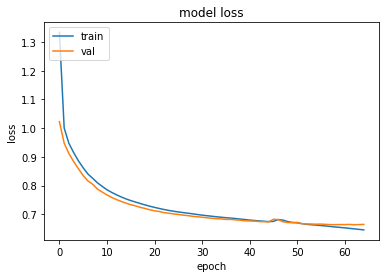

In [5]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [6]:
model.evaluate(x=(test_summaries, test_codes), y=None)

6460/6460 [==============================] - 1s 178us/sample - loss: 0.6662


0.6661824437117798

In [7]:
for _ in range(20):
    random.seed()
    random_idx = random.randrange(test_summaries.shape[0])
    rand_test_summary = np.array([test_summaries[random_idx]])
    print("(Test Set) Input Summary: ", tensor_to_tokenized_texts(rand_test_summary, language_wv)[0])
    rand_test_code = np.array([test_codes[random_idx]])
    print("(Test Set) Input Code: ", tensor_to_tokenized_texts(rand_test_code, code_wv)[0])
    rec_summary = model.language_decoder(model.language_encoder(rand_test_summary).mean()).numpy()
    print("(Test Set) Reconstructed Summary: ", tensor_to_tokenized_texts(rec_summary, language_wv)[0])
    rec_code = model.source_code_decoder(model.source_code_encoder(rand_test_code).mean()).numpy()
    print("(Test Set) Reconstructed Source Code: ", tensor_to_tokenized_texts(rec_code, code_wv)[0])
    rec_summary_hard = model.language_decoder(model.source_code_encoder(rand_test_code).mean()).numpy()
    print("(Test Set) Reconstructed Summary From Source Code: ", tensor_to_tokenized_texts(rec_summary_hard, language_wv)[0])
    rec_code_hard = model.source_code_decoder(model.language_encoder(rand_test_summary).mean()).numpy()
    print("(Test Set) Reconstructed Source Code From Summary: ", tensor_to_tokenized_texts(rec_code_hard, code_wv)[0])
    print()

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


(Test Set) Input Summary:  ['<s>', 'use', 'a', 'text', 'file', 'as', 'storage', 'for', 'a', 'very', 'simple', 'web', 'application', ',', 'how', 'to', 'do', 'locking', '?', '</s>']
(Test Set) Input Code:  ['<s>', 'FileStream', '.', 'Lock', '(', ')', '</s>']
(Test Set) Reconstructed Summary:  ['<s>', '?', 'a', 'file', 'file', 'a', 'downloading', '</s>']
(Test Set) Reconstructed Source Code:  ['<s>', 'IO', '.', 'Ports', '(', 'fileName', '.', '.', '(', '"', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')

In [10]:
language_wv.similar_by_vector(rec_summary[0,3])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('close', 0.7305201888084412),
 ('move', 0.7292052507400513),
 ('disable', 0.7239173650741577),
 ('maximize', 0.719390869140625),
 ('button', 0.7160022854804993),
 ('shutdown', 0.694292426109314),
 ('focus', 0.6900403499603271),
 ('resize', 0.6737217903137207),
 ('window', 0.671488344669342),
 ('panel', 0.663070797920227)]